In [2]:
import numpy as np
import matplotlib.pylab as plt
import sys
sys.path.append('../zdrojaky')
from tsplot import tsplot
from statsmodels import tsa
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings; warnings.simplefilter('ignore')
from statsmodels.api import qqplot
import pandas as pd
plt.rcParams['figure.figsize'] = [10, 5]

# Modelování nestacionární časové řady se sezónními vlivy

Nyní se podíváme na nestacionární časovou řadu se sezónností, konkrétně na již oblíbené letecké cestovatele (viz přednáška). Data jsou uložena v `international-airline-passengers.csv`.

**Úkol: natáhněte data (pozor na hlavičky) a analyzujte je pomocí funkce `tsplot()`. Jaké vlastnosti má časová řada?**

In [19]:
fn = '../zdrojaky/international-airline-passengers.csv'
data = pd.read_csv(fn)
data.Date = pd.to_datetime(data.Date)
data = data.set_index('Date')
data.head()

,Passengers
Date,
1949-01-01,112.0
1949-02-01,118.0
1949-03-01,132.0
1949-04-01,129.0
1949-05-01,121.0


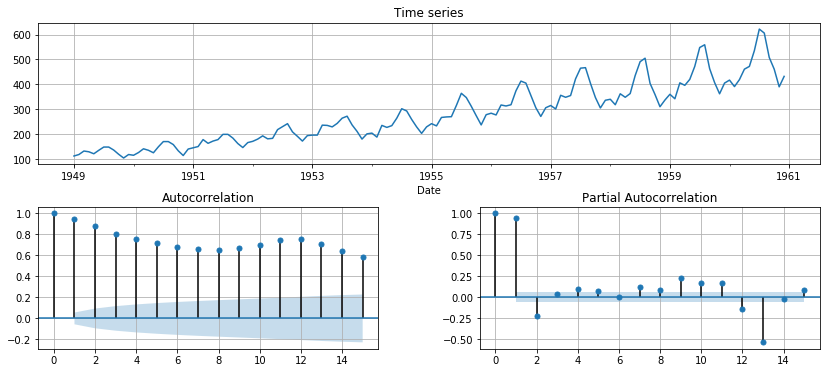

In [20]:
tsplot(data.Passengers)
plt.show()

**Úkol: diferencujte časovou řadu sezónně i nesezónně a analyzujte výsledky.**

In [21]:
dt = data[12:]-data[:-12]
dt = dt[1:]-dt[:-1]

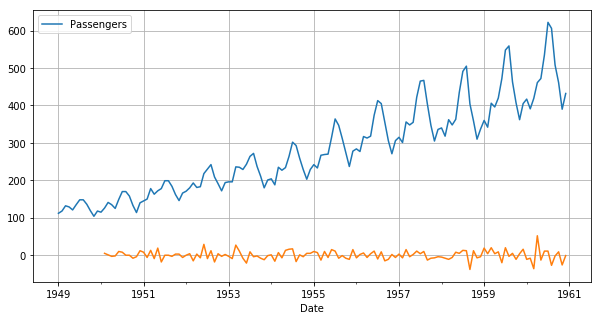

In [22]:
data.plot()
data_d1 = data.Passengers.diff(12).diff(1)
data_d1.plot()

**Úkol: Budeme fitovat pomocí třídy `SARIMAX` z `statsmodels.tsa.statespace.sarimax`. Ozkoušejte několik možných konfigurací parametrů - držte se pravidel z přednášky.**

In [43]:
model = SARIMAX(data, order=(1,1,2), seasonal_order=(0,1,2,12), enforce_invertibility=True)
result = model.fit()
print(result.summary())

                                 Statespace Model Results                                 
Dep. Variable:                         Passengers   No. Observations:                  144
Model:             SARIMAX(1, 1, 2)x(0, 1, 2, 12)   Log Likelihood                -505.562
Date:                            Wed, 06 Nov 2019   AIC                           1023.125
Time:                                    10:39:15   BIC                           1040.943
Sample:                                01-01-1949   HQIC                          1030.365
                                     - 12-01-1960                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4163      1.179     -0.353      0.724      -2.727       1.894
ma.L1          0.0519      1.198   

- [Ljung-Boxův test testuje H0: no autocorrelation of residues](https://www.statsmodels.org/dev/generated/statsmodels.stats.diagnostic.acorr_ljungbox.html)
- [Heteroskedasticity test - H0: no heteroskedasticity](https://www.statsmodels.org/dev/generated/statsmodels.regression.recursive_ls.RecursiveLSResults.test_heteroskedasticity.html)
- [Jarque-Bera - H0: normální distribuce](https://www.statsmodels.org/dev/generated/statsmodels.stats.stattools.jarque_bera.html)

**Úkol: podívejme se nyní na ACF, PACF a řadu reziduí pomocí `tsplot()` a interpretujme výsledky.**

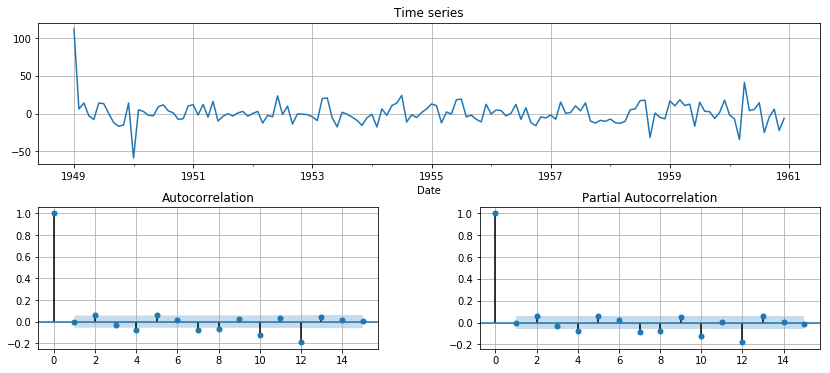

In [44]:
tsplot(result.resid)
plt.show()

**Úkol: vykreslíme histogram reziduí a qq-plot a interpretujeme výsledky.**

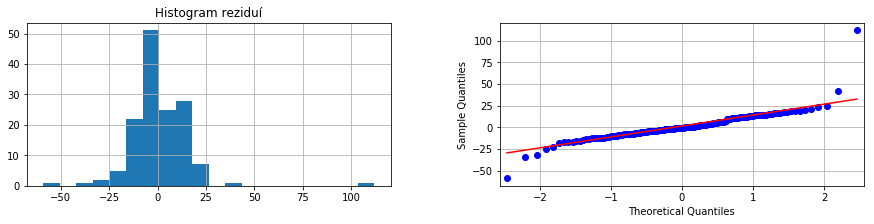

In [45]:
plt.figure(figsize=(15,3))
ax = plt.subplot(1,2,1)
plt.hist(result.resid, bins=20)
plt.title('Histogram reziduí')
ax = plt.subplot(1,2,2)
qqplot(result.resid, line='q', ax=ax)
plt.show()

**Úkol: zkusme nyní predikce na `nsteps` dopředu. K tomu slouží `metoda result.get_forecast()`, která vrátí instanci obsahující mj. atribut `predicted_mean` (predikovaná hodnota) a `summary_frame()`, v němž najdeme kromě predikovaných hodnot i intervaly spolehlivosti. Vykresleme tedy predikce vč. intervalů.**

Passengers,mean,mean_se,mean_ci_lower,mean_ci_upper
1961-01-01,449.172872,11.429504,426.771456,471.574288
1961-02-01,424.859952,13.543012,398.316136,451.403769
1961-03-01,459.832877,15.730192,429.002266,490.663487
1961-04-01,495.582147,17.511469,461.260299,529.903996
1961-05-01,510.033591,19.179281,472.442891,547.624292


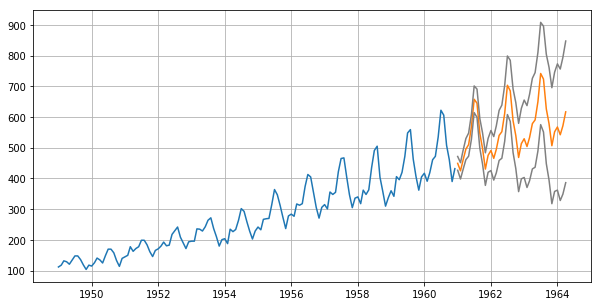

In [46]:
nsteps = 40
fcast = result.get_forecast(steps=nsteps)
plt.plot(data)
plt.plot(fcast.predicted_mean)
plt.plot(fcast.conf_int(), color='gray')
fcast.summary_frame().head()